#
# Imports
#

In [63]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#to counter runntime warning
from scipy.special import expit

#import tensorflow only for the purpose of checking the loss and aktivation functions
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
#tf.compat.v1.disable_eager_execution()


#
# Loading Data and Data Prep
#

In [64]:
# Loading our MNIST dataset
data = load_digits()
X = data['data']
y = data['target']

# one-hot encoding
enc = OneHotEncoder()
y = enc.fit_transform(y.reshape(-1,1)).toarray()

X = X / np.max(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#
# Data_visulisation 
#

In [65]:
# Function to visualize a specific data point at a given index
def data_visualization_index(data, target, index):
    # Create a new figure for the plot with an 8x8-inch size
    plt.figure(figsize=(8, 8))
    
    # Display the image of the data point at the specified index, reshaped to 8x8, in grayscale
    plt.imshow(data[index].reshape(8, 8), cmap='gray')
    
    # Set the title of the plot to the corresponding target value
    plt.title(target[index])
    
    # Turn off the axis labels and ticks for a cleaner visualization
    plt.axis('off')
    
    # Show the plot on the screen
    plt.show() 

# Function to visualize the entire dataset as a single image
def data_visualization(data, target):
    # Create a new figure for the plot with an 8x8-inch size
    plt.figure(figsize=(8, 8))
    
    # Display the entire dataset as a single image, reshaped to 8x8, in grayscale
    plt.imshow(data.reshape(8, 8), cmap='gray')
    
    # Set the title of the plot to the target label (assuming it's a single label for the entire dataset)
    plt.title(target)
    
    # Turn off the axis labels and ticks for a cleaner visualization
    plt.axis('off')
    
    # Show the plot on the screen
    plt.show()

#
# Data_Generator
#

In [66]:
def data_generator(input_data, target_data, minibatch_size):
    # Get the total number of samples in the dataset
    num_samples = len(input_data)
    
    # Create an array of indices corresponding to the samples
    indices = np.arange(num_samples)
    # Shuffle the indices to randomize the order of samples
    np.random.shuffle(indices)

    # Iterate over the shuffled indices to yield mini-batches
    for start_idx in range(0, num_samples - minibatch_size + 1, minibatch_size):
        # Select a subset of indices for the current mini-batch
        excerpt = indices[start_idx:start_idx + minibatch_size]
        
        # Yield the corresponding input and target data for the mini-batch
        yield input_data[excerpt], target_data[excerpt]

#
# Activation functions
#

In [67]:
class Sigmoid:
    def __call__(self, x):
        return expit(x)
    
    def gradient(self,x):
        s = self.__call__(x)
        return s * (1 - s)

    @staticmethod
    def test_sigmoid():
        # Test the Sigmoid class against TensorFlow
        x = np.random.randn(10, 5)
    
        custom_sigmoid = Sigmoid()
        custom_result = custom_sigmoid(x)

        tf_sigmoid = tf.keras.activations.sigmoid
        tf_result = tf_sigmoid(x)

        np.testing.assert_allclose(custom_result, tf_result, rtol=1e-5)

        print("Sigmoid test passed!")



In [68]:
class Softmax:
    def __call__(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exps / np.sum(exps, axis=-1, keepdims=True)
    
    def gradient(self,x):
        s = self.__call__(x)
        return s * (1 - s)
    
    @staticmethod
    def test_softmax():
        # Adjust the scale of random input values
        x = np.random.randn(10, 5) * 0.1
        y_true = tf.keras.utils.to_categorical(np.random.randint(5, size=10), num_classes=5)

        custom_softmax = Softmax()
        custom_result = custom_softmax(x)

        tf_softmax = tf.keras.activations.softmax
        tf_x = tf.convert_to_tensor(x, dtype=tf.float32)
        tf_result = tf_softmax(tf_x).numpy()

        np.testing.assert_allclose(custom_result, tf_result, rtol=1e-5)

        with tf.GradientTape() as tape:
            tape.watch(tf_x)
            tf_result = tf_softmax(tf_x)
    
        tf_grad = tape.gradient(tf_result, tf_x)

        custom_grad = custom_softmax.gradient(custom_result, y_true)

        np.testing.assert_allclose(custom_grad, tf_grad.numpy(), rtol=1e-5)

        print("Softmax test passed!")

In [69]:
class CCE:
    def __call__(self, logits, y_true):
        y_pred = Softmax()(logits)
        loss = -np.sum(y_true * np.log(y_pred + 1e-15), axis=-1)
        return np.mean(loss)
    
    def gradient(self, y_pred, y_true):
        grad = y_pred - y_true
        return grad
    
    @staticmethod
    def test_cce():
        logits = np.random.randn(10, 5)
        y_true = tf.keras.utils.to_categorical(np.random.randint(5, size=10), num_classes=5)

        custom_cce = CCE()
        custom_result = custom_cce(logits, y_true)

        tf_cce = tf.keras.losses.CategoricalCrossentropy()
        tf_result = tf_cce(y_true, logits)

        print("Custom CCE loss:", custom_result)
        print("TensorFlow CCE loss:", tf_result.numpy())
        np.testing.assert_allclose(custom_result, tf_result, rtol=1e-5)

        with tf.GradientTape() as tape:
            tape.watch(logits)
            tf_result = tf_cce(y_true, logits)
            tf_grad = tape.gradient(tf_result, logits)

        custom_grad = custom_cce.gradient(logits, y_true)

        np.testing.assert_allclose(custom_grad, tf_grad.numpy(), rtol=1e-5)

        print("CCE test passed!")

#
# Test The Sigmoid, Softmax and Crossentropy classes
#

In [70]:
Sigmoid.test_sigmoid()
#Softmax.test_softmax()
#CCE.test_cce()

Sigmoid test passed!


#
# MLP and MLP_Layer class
#

In [71]:
class MLP_Layer:
    def __init__(self, input_size, output_size, activation):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        
        # Initialize the weights and biases for the layer
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
        self.biases = np.zeros(output_size)
        
    def forward(self, inputs):
        # Compute the dot product of the inputs and weights, and add the biases
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.biases
        
        # Apply the activation function to the result
        self.output = self.activation(self.z)
        
        return self.output
    
    def backward(self, dvalues):
        # Compute the gradient of the loss with respect to the layer output
        self.dvalues = dvalues
        
        # Compute the gradient of the loss with respect to the layer inputs
        self.dz = self.dvalues * self.activation.gradient(self.z)
        self.dinputs = np.dot(self.dz, self.weights.T)
        
        # Compute the gradient of the loss with respect to the layer weights and biases
        self.dweights = np.dot(self.inputs.T, self.dz)
        self.dbiases = np.sum(self.dz, axis=0)
        
        return self.dinputs


In [72]:
class MLP:
    def __init__(self, input_size, output_size, hidden_sizes, activations):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.activations = activations
        
        # Initialize the layers of the MLP
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            layer = MLP_Layer(layer_sizes[i], layer_sizes[i+1], activations[i])
            self.layers.append(layer)
    
    def forward(self, inputs):
        # Compute the forward pass through the layers of the MLP
        for layer in self.layers:
            inputs = layer.forward(inputs)
        
        # Return the final output of the MLP
        return inputs
    
    def backward(self, dvalues):
        # Compute the backward pass through the layers of the MLP
        for layer in reversed(self.layers):
            dvalues = layer.backward(dvalues)
        
        # Return the gradient of the loss with respect to the MLP inputs
        return dvalues
    
    def train(self, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate):
        # Initialize lists to store the training and testing losses and accuracies
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []
        
        # Iterate over the specified number of epochs
        for epoch in range(epochs):
            # Initialize variables to store the total training loss and accuracy for the current epoch
            train_loss = 0
            train_accuracy = 0
            
            # Iterate over the mini-batches of training data
            for X_batch, y_batch in data_generator(X_train, y_train, batch_size):
                # Compute the forward pass through the MLP
                y_pred = self.forward(X_batch)
                
                # Compute the loss and accuracy for the current mini-batch
                loss = CCE()(y_pred, y_batch)
                train_loss += loss
                train_accuracy += np.sum(np.argmax(y_pred, axis=-1) == np.argmax(y_batch, axis=-1))
                
                # Compute the backward pass through the MLP
                grad = CCE().gradient(y_pred, y_batch)
                self.backward(grad)
                
                # Update the weights and biases of the MLP using gradient descent
                for layer in self.layers:
                    layer.weights -= learning_rate * layer.dweights
                    layer.biases -= learning_rate * layer.dbiases
            
            # Compute the average training loss and accuracy for the current epoch
            train_loss /= len(X_train) / batch_size
            train_accuracy /= len(X_train)
            
            # Initialize variables to store the total testing loss and accuracy for the current epoch
            test_loss = 0
            test_accuracy = 0
            
            # Iterate over the mini-batches of testing data
            for X_batch, y_batch in data_generator(X_test, y_test, batch_size):
                # Compute the forward pass through the MLP
                y_pred = self.forward(X_batch)
                
                # Compute the loss and accuracy for the current mini-batch
                loss = CCE()(y_pred, y_batch)
                test_loss += loss
                test_accuracy += np.sum(np.argmax(y_pred, axis=-1) == np.argmax(y_batch, axis=-1))
            
            # Compute the average testing loss and accuracy for the current epoch
            test_loss /= len(X_test) / batch_size
            test_accuracy /= len(X_test)
            
            # Append the training and testing losses and accuracies to their respective lists
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            
            # Print the training and testing losses and accuracies for the current epoch
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
        
        # Return the training and testing losses and accuracies as numpy arrays
        return np.array(train_losses), np.array(train_accuracies), np.array(test_losses), np.array(test_accuracies)


Epoch 100/1000 - Train Loss: 1.8870 - Train Accuracy: 0.7589 - Test Loss: 1.8173 - Test Accuracy: 0.6907
Epoch 200/1000 - Train Loss: 1.7453 - Train Accuracy: 0.8099 - Test Loss: 1.7001 - Test Accuracy: 0.7296
Epoch 300/1000 - Train Loss: 1.6057 - Train Accuracy: 0.9475 - Test Loss: 1.5626 - Test Accuracy: 0.8704
Epoch 400/1000 - Train Loss: 1.5475 - Train Accuracy: 0.9682 - Test Loss: 1.5070 - Test Accuracy: 0.8852
Epoch 500/1000 - Train Loss: 1.5196 - Train Accuracy: 0.9825 - Test Loss: 1.4860 - Test Accuracy: 0.8907
Epoch 600/1000 - Train Loss: 1.5071 - Train Accuracy: 0.9841 - Test Loss: 1.4745 - Test Accuracy: 0.8963
Epoch 700/1000 - Train Loss: 1.4971 - Train Accuracy: 0.9881 - Test Loss: 1.4686 - Test Accuracy: 0.8981
Epoch 800/1000 - Train Loss: 1.4912 - Train Accuracy: 0.9889 - Test Loss: 1.4668 - Test Accuracy: 0.8944
Epoch 900/1000 - Train Loss: 1.4866 - Train Accuracy: 0.9905 - Test Loss: 1.4622 - Test Accuracy: 0.8926
Epoch 1000/1000 - Train Loss: 1.4835 - Train Accuracy: 

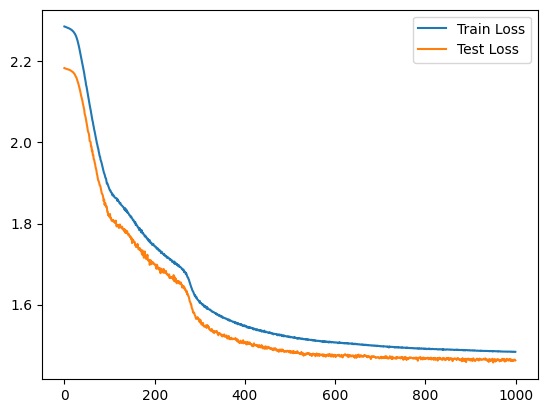

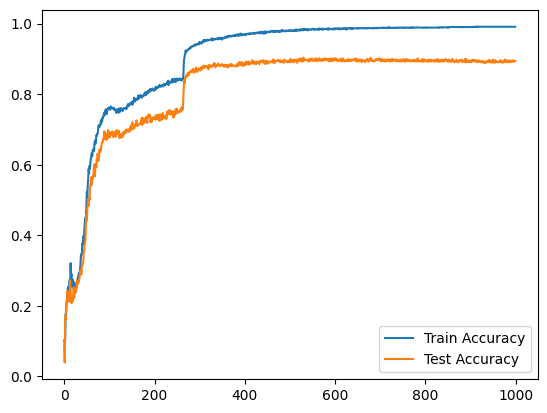

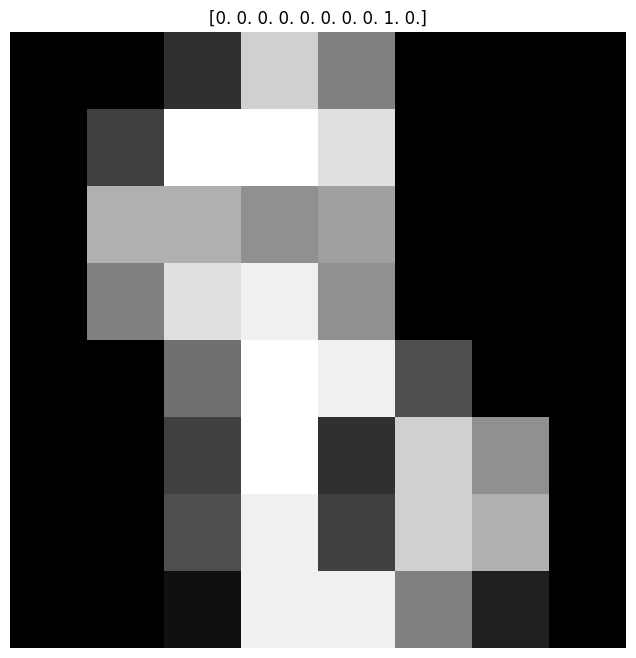

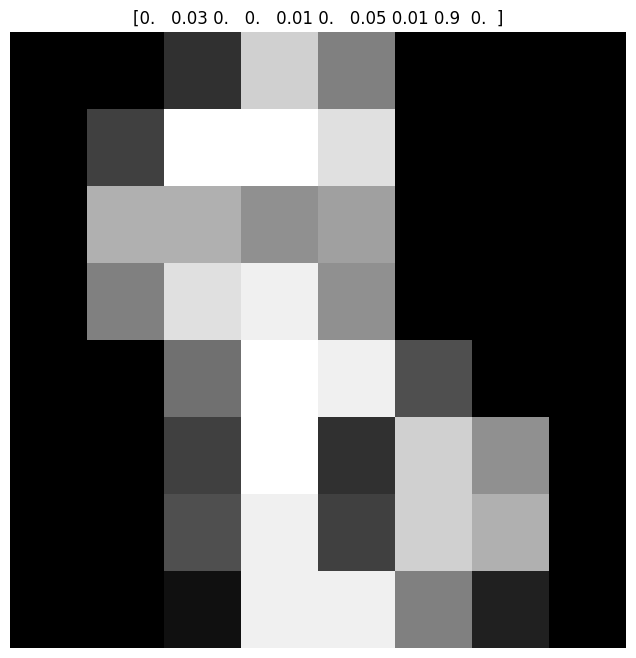

In [73]:
# Define the input size, output size, hidden layer sizes, and activation functions for the MLP
input_size = 64
output_size = 10
hidden_sizes = [32, 16]
epochs = 1000
batchsize = 32
learning_rate = 0.01
activations = [Sigmoid(), Sigmoid(), Softmax()]

# Create an instance of the MLP class
mlp = MLP(input_size, output_size, hidden_sizes, activations)

# Train the MLP using the data from the previous cells
train_losses, train_accuracies, test_losses, test_accuracies = mlp.train(X_train, y_train, X_test, y_test, epochs, batchsize, learning_rate)

# Plot the training and testing losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

# Plot the training and testing accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.show()


# Function to visualize the predictions of the MLP on a random sample of the testing data
y_prediction = mlp.forward(X_test[0:1])
y_prediction = np.round(y_prediction, 2)
data_visualization_index(X_test, y_test, 0)
data_visualization_index(X_test, y_prediction, 0)


In [74]:
x =[3,4,5]
X = np.array(x)
y=[3, -2, 0]
Y = np.array(y)

print(X-Y)

[0 6 5]
